In [5]:
#1. Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.models import VGG19_Weights
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
import time, csv, os
import gradio as gr

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
#2. Image Loader and Preprocessing
image_size = 256 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.detach().cpu().clone().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = torch.clamp(image, 0, 1)
    plt.imshow(image.permute(1, 2, 0))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(tensor.device)
    return tensor * std + mean

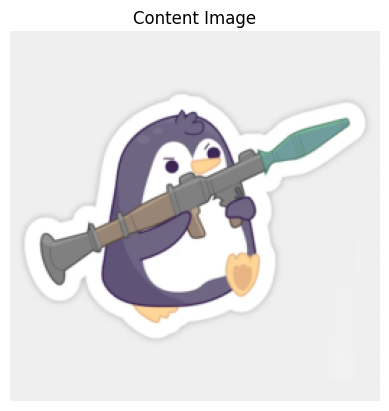

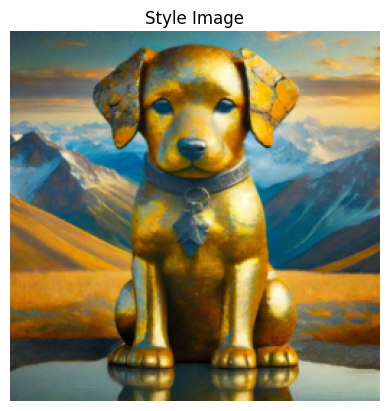

In [9]:
#3. Load Content and Style Images

content_image = load_image(r"C:\Users\user\Desktop\Jupyter Notebooks\FYP\image1.png")
style_image = load_image(r"C:\Users\user\Desktop\Jupyter Notebooks\FYP\image3.png")

# Ensure style matches content dimensions
def match_size_to(img, ref):
    _, _, H, W = ref.shape
    return transforms.functional.resize(img.squeeze(0), (H, W)).unsqueeze(0).to(device)

style_image = match_size_to(style_image, content_image)

imshow(content_image, title="Content Image")
imshow(style_image, title="Style Image")


In [11]:
#4. Define VGG19 and Feature Extractor

vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features.to(device).eval()


# Layer selection
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Feature extractor class
class VGGFeatures(nn.Module):
    def __init__(self, vgg, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.model = nn.Sequential()
        self.layer_names = []
        i = 0

        for layer in vgg.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            else:
                continue
            self.model.add_module(name, layer)
            self.layer_names.append(name)

    def forward(self, x):
        content_features = {}
        style_features = {}
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

feature_extractor = VGGFeatures(vgg, content_layers, style_layers).to(device)


In [12]:
#5. Define Gram Matrix for Style Loss

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

def tensor_to_img01(t):
    x = t.detach().cpu().clone().squeeze(0)
    x = x * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    x = torch.clamp(x, 0, 1)
    return x.permute(1,2,0).numpy()

def compute_ssim(content, output):
    c = tensor_to_img01(content)
    o = tensor_to_img01(output)
    # convert to grayscale SSIM
    c_gray = np.dot(c[...,:3], [0.299, 0.587, 0.114])
    o_gray = np.dot(o[...,:3], [0.299, 0.587, 0.114])
    return ssim(c_gray, o_gray, data_range=1.0)

# Define Logging Utility for Hyperparameter Sweep

def log_result(csv_path, content_w, style_w, steps, ssim_score, secs):
    header = ["content_weight","style_weight","steps","ssim","seconds"]
    new = [content_w, style_w, steps, round(ssim_score,4), round(secs,2)]
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        w = csv.writer(f)
        if write_header: 
            w.writerow(header)
        w.writerow(new)

In [15]:
#6. Prepare Target Image for Optimisation

target = content_image.clone().requires_grad_(True).to(device)


In [17]:
#7. Optimise Target Image

style_weight = 1e6
content_weight = 1

# Optimise image directly
optimizer = optim.LBFGS([target])

num_steps = 100
run = [0]

# Extract content and style features
content_features, _ = feature_extractor(content_image)
_, style_features = feature_extractor(style_image)

# Start Timer
t0 = time.time() 

while run[0] <= num_steps:

    def closure():
        optimizer.zero_grad()

        # Forward pass: extract features from current target image
        target_content, target_style = feature_extractor(target)

        content_loss = 0
        style_loss = 0

        # Content loss
        for layer in content_layers:
            content_loss += nn.functional.mse_loss(
                target_content[layer], content_features[layer]
            )

        # Style loss using Gram matrices
        for layer in style_layers:
            G = gram_matrix(target_style[layer])
            A = gram_matrix(style_features[layer])
            style_loss += nn.functional.mse_loss(G, A)

        # Total loss
        total_loss = content_weight * content_loss + style_weight * style_loss

        # To avoid "graph has been freed" error
        total_loss.backward(retain_graph=True)

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]} | Content Loss: {content_loss.item():.4f} | Style Loss: {style_loss.item():.4f}")

        return total_loss

    optimizer.step(closure)

# End Timer
secs = time.time() - t0

# logs results
score = compute_ssim(content_image, target)
log_result("sweep_results_test.csv", content_weight, style_weight, num_steps, score, secs)


Step 50 | Content Loss: 21.7155 | Style Loss: 0.0006
Step 100 | Content Loss: 24.8447 | Style Loss: 0.0002


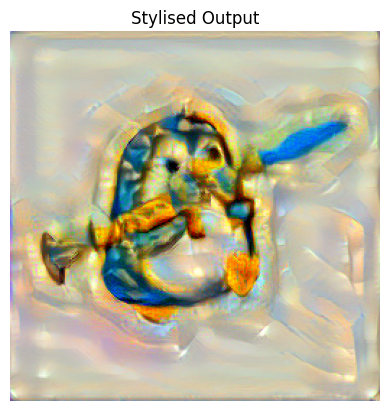

Stylised image saved as 'stylised_output.jpg'


In [19]:
#8. Show and Save Final Output
imshow(target, title="Stylised Output")
save_image(target, "stylised_output.jpg")
print("Stylised image saved as 'stylised_output.jpg'")


In [21]:
#9. Hyperparameter Sweep

def stylise_once(content_image, style_image, content_weight, style_weight, num_steps=100):
    target = content_image.clone().requires_grad_(True).to(device)
    optimizer = optim.LBFGS([target])

    # Extract features once
    content_features, _ = feature_extractor(content_image)
    _, style_features = feature_extractor(style_image)

    run = [0]
    t0 = time.time()

    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            target_content, target_style = feature_extractor(target)

            content_loss = 0
            style_loss = 0

            for layer in content_layers:
                content_loss += nn.functional.mse_loss(target_content[layer], content_features[layer])

            for layer in style_layers:
                G = gram_matrix(target_style[layer])
                A = gram_matrix(style_features[layer])
                style_loss += nn.functional.mse_loss(G, A)

            total_loss = content_weight * content_loss + style_weight * style_loss
            total_loss.backward(retain_graph=True)
            run[0] += 1
            return total_loss
        optimizer.step(closure)

    secs = time.time() - t0
    score = compute_ssim(content_image, target)
    return target.detach(), score, secs


In [23]:
os.makedirs("results", exist_ok=True)

num_steps = 100
s_weights = [1e5, 5e5, 1e6]
c_weights = [1, 5, 10]

for sw in s_weights:
    for cw in c_weights:
        out, score, secs = stylise_once(content_image, style_image, cw, sw, num_steps=num_steps)
        fname = f"results/out_c{cw}_s{int(sw)}.jpg"
        out_denorm = denormalize(out.squeeze(0).cpu())
        save_image(out_denorm, fname)
        log_result("sweep_results.csv", cw, sw, num_steps, score, secs)
        print(f"Saved {fname} | SSIM={score:.3f} | {secs:.1f}s")


Saved results/out_c1_s100000.jpg | SSIM=0.707 | 8.1s
Saved results/out_c5_s100000.jpg | SSIM=0.806 | 8.0s
Saved results/out_c10_s100000.jpg | SSIM=0.840 | 8.3s
Saved results/out_c1_s500000.jpg | SSIM=0.615 | 8.7s
Saved results/out_c5_s500000.jpg | SSIM=0.711 | 8.8s
Saved results/out_c10_s500000.jpg | SSIM=0.753 | 8.8s
Saved results/out_c1_s1000000.jpg | SSIM=0.591 | 9.0s
Saved results/out_c5_s1000000.jpg | SSIM=0.671 | 9.2s
Saved results/out_c10_s1000000.jpg | SSIM=0.701 | 9.1s


In [ ]:
#10. Gradio UI

# Runs style transfer once (simplified for UI)
def run_nst(content_img, style_img, style_weight=1e6, content_weight=1, steps=200):
    # Preprocess uploaded images
    content = loader(content_img).unsqueeze(0).to(device)
    style = loader(style_img).unsqueeze(0).to(device)

    
    out, _, _ = stylise_once(content, style, content_weight, style_weight, num_steps=steps)

    # Denormalize before returning
    out_denorm = denormalize(out.squeeze(0).cpu())
    return transforms.ToPILImage()(out_denorm)

# Launch Gradio Interface
demo = gr.Interface(
    fn=run_nst,
    inputs=[
        gr.Image(type="pil", label="Content Image"),
        gr.Image(type="pil", label="Style Image"),
        gr.Slider(1e4, 1e7, value=1e6, step=1e5, label="Style Weight"),
        gr.Slider(1, 20, value=1, step=1, label="Content Weight"),
        gr.Slider(50, 300, value=200, step=50, label="Steps"),
    ],
    outputs=gr.Image(type="pil", label="Stylised Output"),
    title="Neural Style Transfer Demo",
    description="Upload a content and style image, adjust weights, and generate stylised art."
)

demo.launch(share=True, debug=True, inline=False)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://504e26e2465377b208.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
